# Sentiment Analysis Project

## Introduction and Problem Statement
Sentiment analysis is a key area in machine learning that focuses on analyzing emotions expressed in text. It has significant applications in determining public opinion, customer feedback, and social media analysis
### Submission
- Deadline of submission:
19.08.2024 23:59

## Dataset Description
- `data.csv`: Contains tweets with labels for training.
- `data_validation.csv`: Used to evaluate the model with unseen data.

### Task 1
Find a way to load the dataset and transform the features `X` (Tweets) and the labels `Y` (positive/negative).

In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix

In [2]:
# TODO: load data, transform into numerical features + labels
df = pd.read_csv('data.csv', names=['labels', 'tweets'], header=None, skiprows=1)
# Select the first 10,000 data points
df = df.head(100000)

# Extract features and labels
X = df['tweets']
y = df['labels']

### Task 2
Write a function to clean the tweets the data from special symbols, several and more.

In [3]:
def clean_tweet(tweet):
    tweet = re.sub(r'http\S+', '', tweet)  # Remove URLs
    tweet = re.sub(r'@\w+', '', tweet)  # Remove mentions
    tweet = re.sub(r'#\w+', '', tweet)  # Remove hashtags
    tweet = re.sub(r'\d+', '', tweet)  # Remove numbers
    tweet = re.sub(r'\W+', ' ', tweet)  # Remove special characters
    tweet = tweet.lower().strip()  # Convert to lowercase and strip whitespaces
    return tweet

# Apply the cleaning function to each tweet
X = X.apply(clean_tweet)

### Task 3
Find a way to transform the features `X` (tweets) and the labels `Y` (positive/negative) into numerical representations.

For transforming tweets into features, check out the bag of words representation from [scikit-learn](https://scikit-learn.org/stable/modules/feature_extraction.html)

In [4]:
vectorizer = CountVectorizer(max_features=5000)
x_sparse = vectorizer.fit_transform(X).toarray()

print(x_sparse.shape)

(100000, 5000)


## Prior $p(S)$

The prior distribution $p(S)$ is independent of the message $W$. We will use the maximum likelihood (ML) estimate for a categorical distribution, which is the relative frequency of the categories among the dataset.
\begin{align}
p(S = \text{positive})_{ML} &= \cfrac{\text{\# tweets that are positive}}{\text{\# tweets}}\\
p(S = \text{negative})_{ML} &= 1 - p(S = \text{negative})
\end{align}

### Task 4

Estimate $p(S)$. Display the estimated distribution in a bar chart.

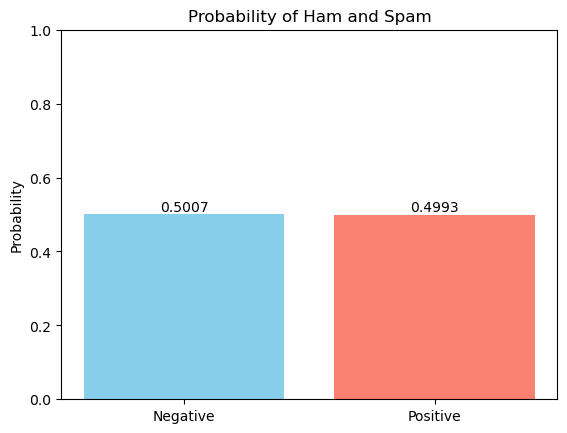

In [5]:
import matplotlib.pyplot as plt

# TODO: estimate p(S), display in bar chart
p_positve = np.mean(y)
p_negative = 1 - p_positve


# Creating the plot
labels = ['Negative', 'Positive']
values = [p_negative, p_positve]

fig, ax = plt.subplots()
bars = ax.bar(labels, values, color=['skyblue', 'salmon'])

# Adding value labels on top of each bar
for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 4), ha='center', va='bottom')

# Adding titles and labels
ax.set_ylabel('Probability')
ax.set_title('Probability of Ham and Spam')
plt.ylim(0, 1)  # Set y-axis limits to show probabilities clearly from 0 to 1
plt.show()

## Likelihood p(W|S)

The likelihood distribution models how likely a tweets is, given we know its either positive or negative.

\text{tweet}]$ we would expect something like 
\begin{align}
p(W|S=\text{positive}) &= \text{low}\\
p(W|S=\text{negative}) &= \text{medium}\\
\end{align}

However to estimate $p(W|S)$ we would need a dataset with the exact same $W$ appearing in both contexts: positive and negative. Since this is not the case for our dataset, this is the part where we make a naive assumption:
\begin{align}
p(W|S) = \prod_{w\in W}p(w|S)
\end{align}
That is, we consider each word in the tweet independend of the others. This simplification enables us to estimate the likelihood, since single words to in fact appear in both contexts.

For a single word $w$, we can again estimate the probability as relative frequency 
\begin{align}
p(w|S = \text{positive})_{ML} &= \cfrac{\text{\# word $w$ is labeled posotive}}{\text{\# any word is labeled positive}}\\
p(w|S = \text{negative})_{ML} &= \cfrac{\text{\# word $w$ is labeled negative}}{\text{\# any word is labeled negative}}\\
\end{align}

Since we cannot expect every word to have appeared in a positive and negative tweet, we will smooth our dataset with a [Laplace smoothing](https://en.wikipedia.org/wiki/Additive_smoothing) of $\varepsilon = 0.001$. 

This is done by adding $\varepsilon$ to the count of every word in every SMS.

As an example the count vector for a SMS over a vocabulary of 5 words is transformed from
\begin{align}
[1, 2, 0, 0, 1]
\end{align}
into
\begin{align}
[1.001, 2.001, 0.001, 0.001, 1.001]\,.
\end{align}

This way we do not have zero probabilities in the product for calculating $p(W|S)$.

In [6]:
# TODO: apply Laplace smoothing
x_smooth = x_sparse + 0.001

In [7]:
import numpy.typing as npt
from typing import Self


class NaiveBayesClassifier():
    def __init__(self, laplace_smoothing_constant: float = 0.0001):
        """Class for binary naive Bayes."""

        self.laplace_regularization_constant = laplace_smoothing_constant
        # n_labels x n_words
        self.log_p_word_given_label: npt.NDArray[np.float64] = None
        # n_labels
        self.log_p_label: npt.NDArray[np.float64] = None

    def fit(self, x: npt.NDArray[np.float64], y: npt.NDArray[np.bool_]) -> Self:
        """Given a dataset of count vectors, calculates probabilities needed for prediction.

        Parameters
        ----------
        x : npt.NDArray[np.float64]
            Word count matrix (n_sms x n_words).
        y : npt.NDArray[np.bool_]
            Label matrix (n_sms).
        """
        
        # TODO: implement
        self.log_p_label= [np.log(np.sum(y)/ len(y)), np.log(1-np.sum(y)/ len(y))]
        x_smooth=x+self.laplace_regularization_constant
        spam_words= x_smooth[y==1].sum(axis=0)
        ham_words= x_smooth[y==0].sum(axis=0)
        self.log_p_word_given_label= np.array([[np.log(spam_words[i]/np.sum(spam_words)) for i in range(x.shape[1])], 
                                      [np.log(ham_words[i]/np.sum(ham_words)) for i in range(x.shape[1])]])
        return self

    def predict(self, x: npt.NDArray[np.float64]) -> npt.NDArray[np.bool_]:
        """Given a dataset of count vectors, predicts labels.

        Parameters
        ----------
        x : npt.NDArray[np.float64]
            Word count matrix (n_sms x n_words).

        Returns
        -------
        npt.NDArray[np.bool_]
            Vector of predictions for labels (0 = ham, 1 = spam).
        """

        # TODO: implement
        spam=[np.sum(self.log_p_word_given_label[0,x[i]!=0])+self.log_p_label[0] for i in range(x.shape[0])]
        ham= [np.sum(self.log_p_word_given_label[1,x[i]!=0])+self.log_p_label[1] for i in range(x.shape[0])]
        return [spam[i]>=ham[i] for i in range(len(spam))]
        

    def accuracy(self, x: npt.NDArray[np.float64], y: npt.NDArray[np.bool_]) -> float:
        """Calculates accuracy for given dataset.

        Parameters
        ----------
        x : npt.NDArray[np.float64]
            Word count matrix (n_sms x n_words).
        y : npt.NDArray[np.bool_]
            Vector of true labels (0 = ham, 1 = spam).

        Returns
        -------
        float
            Percentage of correctly classified x.
        """

        # TODO: implement
        return np.sum(np.where(self.predict(x)==y, 1, 0))/len(y)


# assertions
classifier = NaiveBayesClassifier(laplace_smoothing_constant=0.0001).fit(x_sparse, y)

In [8]:
from sklearn.model_selection import train_test_split
# TODO: provide train + testsplit
X_train, X_test, y_train, y_test = train_test_split(x_sparse, y, test_size=0.2, random_state=42)
print(X_train.shape)

(80000, 5000)


In [9]:
results = []
def evaluate_model(model_name, y_true, y_pred, pos_label=1):
    accuracy = accuracy_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred, pos_label=pos_label)
    precision = precision_score(y_true, y_pred, pos_label=pos_label)
    f1 = f1_score(y_true, y_pred, pos_label=pos_label)
    conf_matrix = confusion_matrix(y_true, y_pred)
    
    results.append({
        'model': model_name,
        'accuracy': accuracy,
        'recall': recall,
        'precision': precision,
        'f1_score': f1,
        'confusion_matrix': conf_matrix
    })

In [ ]:
# Model training with Naive Bayes approach
model = NaiveBayesClassifier(laplace_smoothing_constant=0.0002)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print('Naive Bayes')
evaluate_model('Naive Bayes', y_test, y_pred)
print('Naive Bayes')

In [ ]:
# Model training with Logistic Regression approach
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print('Logistic Regression')
evaluate_model('Logistic Regression', y_test, y_pred)

In [ ]:
from sklearn.svm import SVC
# Model training with Support Vector Machine approach
model = SVC(kernel='linear')
model.fit(X_train, y_train)
print('train')
y_pred = model.predict(X_test)
print('Support Vector Machine')
evaluate_model('SVM', y_test, y_pred)

In [ ]:
def plot_metrics(results):
    models = [result['model'] for result in results]
    accuracies = [result['accuracy'] for result in results]
    recalls = [result['recall'] for result in results]
    precisions = [result['precision'] for result in results]
    f1_scores = [result['f1_score'] for result in results]

    fig, axs = plt.subplots(2, 2, figsize=(14, 10))

    axs[0, 0].bar(models, accuracies, color='skyblue')
    axs[0, 0].set_title('Accuracy')
    axs[0, 0].set_ylim([0, 1])
    
    axs[0, 1].bar(models, recalls, color='lightgreen')
    axs[0, 1].set_title('Recall')
    axs[0, 1].set_ylim([0, 1])
    
    axs[1, 0].bar(models, precisions, color='salmon')
    axs[1, 0].set_title('Precision')
    axs[1, 0].set_ylim([0, 1])
    
    axs[1, 1].bar(models, f1_scores, color='lightcoral')
    axs[1, 1].set_title('F1 Score')
    axs[1, 1].set_ylim([0, 1])
    
    for ax in axs.flat:
        ax.set_xticks(range(len(models)))
        ax.set_xticklabels(models)
        ax.set_xlabel('Model')
        ax.set_ylabel('Score')
    
    plt.tight_layout()
    plt.show()

# Plot the metrics
plot_metrics(results)